## Readme

Necessary Packages to install:
- pandas
- pytorch
- transformers
- scikit-learn
- matplotlib
- openai

Necessary Files:
- gender-classifier-DFE-791531.csv (twitter dataset)
- generated_tweets_chatgpt.csv (synthetic dataset)

In [1]:
import pandas as pd
import torch
import os
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path_to_dir = "/content/drive/MyDrive/Fourth Year/Winter 2025/NLP Project/"
path_to_dir = "./"
#path_to_dir = "/content/drive/MyDrive/Fourth Year/Winter 2025/NLP Project/"
# change path_to_dir for each person. this robert's personal path
twitter_gender_dataset = pd.read_csv(f"{path_to_dir}gender-classifier-DFE-791531.csv", encoding="latin1")

In [ ]:
#OJ Path
#path_to_dir = "/content/drive/MyDrive/nlp/NLP Project/"
#twitter_gender_dataset = pd.read_csv(f"{path_to_dir}gender-classifier-DFE-791531.csv", encoding="latin1")

In [3]:
twitter_gender_dataset_preprocessed = twitter_gender_dataset[twitter_gender_dataset['gender:confidence'] == 1]
twitter_gender_dataset_preprocessed = twitter_gender_dataset_preprocessed[twitter_gender_dataset_preprocessed['profile_yn:confidence'] == 1]
twitter_gender_dataset_preprocessed = twitter_gender_dataset_preprocessed[twitter_gender_dataset_preprocessed['profile_yn'] == 'yes']
twitter_gender_dataset_preprocessed = twitter_gender_dataset_preprocessed[twitter_gender_dataset_preprocessed['gender'].isin(['male', 'female', 'brand'])]
twitter_gender_dataset_preprocessed.drop(['_golden', '_unit_state' , '_trusted_judgments', '_last_judgment_at', 'profileimage','gender:confidence', 'profile_yn:confidence', 'profile_yn', 'gender_gold', 'link_color', 'tweet_coord', 'profile_yn_gold', 'sidebar_color'], axis=1, inplace=True)

In [4]:
twitter_fake_dataset_2000 = pd.read_csv(f"{path_to_dir}generated_tweets_2000.csv", encoding="latin1")

In [6]:
training_cutoff = 5000
testing_cutoff = 7500
train_dataset_range = (0, training_cutoff) # increase this value when training on more data
test_dataset_range = (train_dataset_range[1] + 1, testing_cutoff)
EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 2e-5

# Base Model (Bert Trained)

In [7]:
smaller_dataset_pre = twitter_gender_dataset_preprocessed[:train_dataset_range[1]]
smaller_dataset = pd.concat([smaller_dataset_pre, twitter_fake_dataset_2000])
texts = smaller_dataset['text'].tolist()
labels = smaller_dataset['gender'].tolist()

In [8]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [9]:
label_map = {"male": 0, "female": 1, "brand": 2}

In [10]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128, label_map=label_map):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_map = label_map

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        numeric_label = self.label_map[label]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(numeric_label, dtype=torch.long)
        }

In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_map))

train_dataset = TweetDataset(train_texts, train_labels, tokenizer, max_len=128)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, max_len=128)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def train_model(model, train_dataloader, val_dataloader, epochs=EPOCHS, learning_rate=LEARNING_RATE):
  """Trains a PyTorch model using the provided data loaders.

  Args:
      model: The PyTorch model to train.
      train_dataloader: A PyTorch DataLoader for the training data.
      val_dataloader: A PyTorch DataLoader for the validation data.
      epochs: The number of training epochs. Defaults to `EPOCHS`.
      learning_rate: The learning rate for the optimizer. Defaults to `LEARNING_RATE`.

  Returns:
      None. The function modifies the model in-place.
  """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
  epochs = EPOCHS
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  for epoch in range(epochs):
      model.train()
      total_train_loss = 0
      for batch in train_dataloader:
          optimizer.zero_grad()

          input_ids = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels_batch = batch["labels"].to(device)

          outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels_batch)
          loss = outputs.loss
          total_train_loss += loss.item()

          loss.backward()
          optimizer.step()
          scheduler.step()

      avg_train_loss = total_train_loss / len(train_dataloader)
      print(f"Epoch {epoch+1}/{epochs} - Average Training Loss: {avg_train_loss:.4f}")

      model.eval()
      predictions = []
      true_labels = []
      with torch.no_grad():
          for batch in val_dataloader:
              input_ids = batch["input_ids"].to(device)
              attention_mask = batch["attention_mask"].to(device)
              labels_batch = batch["labels"].to(device)

              outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels_batch)
              logits = outputs.logits
              preds = torch.argmax(logits, dim=1)

              predictions.extend(preds.cpu().numpy())
              true_labels.extend(labels_batch.cpu().numpy())

      accuracy = accuracy_score(true_labels, predictions)
      report = classification_report(true_labels, predictions, target_names=["male", "female", "brand"])

      print("Accuracy:", accuracy)
      print("Classification Report:\n", report)

  return accuracy, report

In [13]:
def write_accuracy_report(name, accuracy, report):
    f = open(f"{path_to_dir}charts_with_fake_tweets.txt", "a")
    f.write(name + "\n")
    f.write("Accuracy: " + str(accuracy) + "\n")
    f.write("Report: " + str(report) + "\n")
    f.write("-------------\n")
    f.close()

In [14]:
accuracy_base, report_base = train_model(model, train_dataloader, val_dataloader)
write_accuracy_report("Base Model IS", accuracy_base, report_base)

/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Average Training Loss: 0.8148
Accuracy: 0.5914285714285714
Classification Report:
               precision    recall  f1-score   support

        male       0.49      0.41      0.45       473
      female       0.61      0.46      0.53       494
       brand       0.64      0.94      0.76       433

    accuracy                           0.59      1400
   macro avg       0.58      0.60      0.58      1400
weighted avg       0.58      0.59      0.57      1400

Epoch 2/10 - Average Training Loss: 0.6493
Accuracy: 0.6757142857142857
Classification Report:
               precision    recall  f1-score   support

        male       0.59      0.57      0.58       473
      female       0.64      0.63      0.63       494
       brand       0.81      0.85      0.83       433

    accuracy                           0.68      1400
   macro avg       0.68      0.68      0.68      1400
weighted avg       0.67      0.68      0.67      1400

Epoch 3/10 - Average Training Loss: 0.4334
Acc

In [15]:
smaller_dataset_test = twitter_gender_dataset_preprocessed[test_dataset_range[0]:test_dataset_range[1]]

In [16]:
test_texts = smaller_dataset_test['text'].tolist()
true_labels = smaller_dataset_test['gender'].tolist()
true_labels = [label_map[label] for label in true_labels]

In [17]:
def test_model(model, test_texts, true_labels):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  encoded_inputs = tokenizer(
    test_texts,
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
  )
  encoded_inputs = {k: v.to(device) for k, v in encoded_inputs.items()}
  model.eval()
  with torch.no_grad():
      outputs = model(**encoded_inputs)
      logits = outputs.logits
  predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
  accuracy = accuracy_score(true_labels, predicted_labels)
  report = classification_report(true_labels, predicted_labels, target_names=["male", "female", "brand"])

  print("Accuracy:", accuracy)
  print("Classification Report:\n", report)
  return predicted_labels, accuracy, report

In [18]:
predicted_labels, accuracy, report = test_model(model, test_texts, true_labels)
write_accuracy_report("Base Model OOS", accuracy, report)

Accuracy: 0.6110444177671068
Classification Report:
               precision    recall  f1-score   support

        male       0.49      0.57      0.53       777
      female       0.59      0.57      0.58       867
       brand       0.77      0.69      0.73       855

    accuracy                           0.61      2499
   macro avg       0.62      0.61      0.61      2499
weighted avg       0.62      0.61      0.61      2499



# Adding Metadata

Metadata used: name ('name'), profile bio ('description'), location ('tweet_location')

In [44]:
twitter_gender_dataset_metadata = twitter_gender_dataset_preprocessed.copy()
twitter_gender_dataset_metadata = pd.concat([twitter_fake_dataset_2000, twitter_gender_dataset_metadata])
metadata = {'profile': twitter_gender_dataset_metadata['description']}
twitter_gender_dataset_metadata['text_all_metadata'] = 'name:' + twitter_gender_dataset_metadata['name'].fillna('') + ' tweet:' + twitter_gender_dataset_metadata['text'].fillna('') + ' profile:' + twitter_gender_dataset_metadata['description'].fillna('') + ' location:' + twitter_gender_dataset_metadata['tweet_location'].fillna('')
twitter_gender_dataset_metadata['text_name'] = 'name:' + twitter_gender_dataset_metadata['name'].fillna('') + ' tweet:' + twitter_gender_dataset_metadata['text'].fillna('')
twitter_gender_dataset_metadata['text_description'] = 'tweet:' + twitter_gender_dataset_metadata['text'].fillna('') + ' profile:' + twitter_gender_dataset_metadata['description'].fillna('')
twitter_gender_dataset_metadata['text_name_description'] = 'name:' + twitter_gender_dataset_metadata['name'].fillna('') + ' tweet:' + twitter_gender_dataset_metadata['text'].fillna('') + ' profile:' + twitter_gender_dataset_metadata['description'].fillna('')
twitter_gender_dataset_metadata['text_location'] = 'tweet:' + twitter_gender_dataset_metadata['text'].fillna('') + ' location:' + twitter_gender_dataset_metadata['tweet_location'].fillna('')

twitter_gender_dataset_metadata.head()

,_unit_id,gender,created,description,fav_number,name,retweet_count,text,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone,text_all_metadata,text_name,text_description,text_name_description,text_location
0,0,male,NaN,"Passionate about tech, coffee, and travel. Avi...",NaN,@UrbanNomadFrank,NaN,Just had an inspiring conversation that remind...,NaN,NaN,NaN,"Frankfurt, Germany",NaN,name:@UrbanNomadFrank tweet:Just had an inspir...,name:@UrbanNomadFrank tweet:Just had an inspir...,tweet:Just had an inspiring conversation that ...,name:@UrbanNomadFrank tweet:Just had an inspir...,tweet:Just had an inspiring conversation that ...
1,1,female,NaN,"Passionate about art, culture, and coffee. Exp...",NaN,@UrbanVibesKÃ¶ln,NaN,Just finished a great book and my mind is over...,NaN,NaN,NaN,"Cologne, Germany",NaN,name:@UrbanVibesKÃ¶ln tweet:Just finished a gr...,name:@UrbanVibesKÃ¶ln tweet:Just finished a gr...,tweet:Just finished a great book and my mind i...,name:@UrbanVibesKÃ¶ln tweet:Just finished a gr...,tweet:Just finished a great book and my mind i...
2,2,female,NaN,"Dreamer, storyteller, and coffee enthusiast. E...",NaN,@TokyoDreamer88,NaN,Just found a hidden gem of a cafÃ© in the city...,NaN,NaN,NaN,"Tokyo, Japan",NaN,name:@TokyoDreamer88 tweet:Just found a hidden...,name:@TokyoDreamer88 tweet:Just found a hidden...,tweet:Just found a hidden gem of a cafÃ© in th...,name:@TokyoDreamer88 tweet:Just found a hidden...,tweet:Just found a hidden gem of a cafÃ© in th...
3,3,female,NaN,Coffee enthusiast | Art lover | Exploring the ...,NaN,@ViennaWhispers,NaN,Exploring new spaces and ideas can really open...,NaN,NaN,NaN,"Vienna, Austria",NaN,name:@ViennaWhispers tweet:Exploring new space...,name:@ViennaWhispers tweet:Exploring new space...,tweet:Exploring new spaces and ideas can reall...,name:@ViennaWhispers tweet:Exploring new space...,tweet:Exploring new spaces and ideas can reall...
4,4,male,NaN,"Exploring the world through art, literature, a...",NaN,@NevaVoyager,NaN,Exploring the beauty and history around me ins...,NaN,NaN,NaN,"Saint Petersburg, Russia",NaN,name:@NevaVoyager tweet:Exploring the beauty a...,name:@NevaVoyager tweet:Exploring the beauty a...,tweet:Exploring the beauty and history around ...,name:@NevaVoyager tweet:Exploring the beauty a...,tweet:Exploring the beauty and history around ...


In [45]:
smaller_dataset_metadata = twitter_gender_dataset_metadata[:train_dataset_range[1] + 2000]
text_all_metadata = smaller_dataset_metadata['text_all_metadata'].tolist()
text_name = smaller_dataset_metadata['text_name'].tolist()
text_description = smaller_dataset_metadata['text_description'].tolist()
text_name_description = smaller_dataset_metadata['text_name_description'].tolist()
text_location = smaller_dataset_metadata['text_location'].tolist()
labels_metadata = smaller_dataset_metadata['gender'].tolist()

In [46]:
def train_model_full(texts, labels):
  train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
  )
  tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
  model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_map))

  train_dataset = TweetDataset(train_texts, train_labels, tokenizer, max_len=128)
  val_dataset = TweetDataset(val_texts, val_labels, tokenizer, max_len=128)

  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
  accuracy, report = train_model(model, train_dataloader, val_dataloader)
  return model, accuracy, report

In [47]:
model_all_metadata, accuracy, report = train_model_full(text_all_metadata, labels_metadata)
write_accuracy_report("All Metadata IS", accuracy, report)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Average Training Loss: 0.5928
Accuracy: 0.8228571428571428
Classification Report:
               precision    recall  f1-score   support

        male       0.73      0.82      0.77       482
      female       0.80      0.77      0.79       495
       brand       0.98      0.89      0.93       423

    accuracy                           0.82      1400
   macro avg       0.84      0.83      0.83      1400
weighted avg       0.83      0.82      0.83      1400

Epoch 2/10 - Average Training Loss: 0.3211
Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

        male       0.73      0.85      0.79       482
      female       0.86      0.72      0.78       495
       brand       0.94      0.93      0.94       423

    accuracy                           0.83      1400
   macro avg       0.84      0.84      0.83      1400
weighted avg       0.84      0.83      0.83      1400

Epoch 3/10 - Average Training Loss: 0.1699
Accuracy: 0.84714

In [68]:
model_name, accuracy, report = train_model_full(text_name, labels_metadata)
write_accuracy_report("Name IS", accuracy, report)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Average Training Loss: 0.8980
Accuracy: 0.6207142857142857
Classification Report:
               precision    recall  f1-score   support

        male       0.54      0.42      0.47       482
      female       0.60      0.57      0.58       495
       brand       0.69      0.91      0.79       423

    accuracy                           0.62      1400
   macro avg       0.61      0.63      0.61      1400
weighted avg       0.61      0.62      0.61      1400

Epoch 2/10 - Average Training Loss: 0.6450
Accuracy: 0.7385714285714285
Classification Report:
               precision    recall  f1-score   support

        male       0.68      0.72      0.70       482
      female       0.84      0.59      0.69       495
       brand       0.73      0.93      0.82       423

    accuracy                           0.74      1400
   macro avg       0.75      0.75      0.74      1400
weighted avg       0.75      0.74      0.73      1400

Epoch 3/10 - Average Training Loss: 0.3858
Acc

In [69]:
model_description, accuracy, report  = train_model_full(text_description, labels_metadata)
write_accuracy_report("Bio IS", accuracy, report)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Average Training Loss: 0.8137
Accuracy: 0.6014285714285714
Classification Report:
               precision    recall  f1-score   support

        male       0.35      0.12      0.18       482
      female       0.51      0.88      0.64       495
       brand       0.94      0.82      0.87       423

    accuracy                           0.60      1400
   macro avg       0.60      0.61      0.57      1400
weighted avg       0.58      0.60      0.55      1400

Epoch 2/10 - Average Training Loss: 0.6347
Accuracy: 0.7514285714285714
Classification Report:
               precision    recall  f1-score   support

        male       0.68      0.73      0.70       482
      female       0.80      0.60      0.69       495
       brand       0.79      0.96      0.86       423

    accuracy                           0.75      1400
   macro avg       0.76      0.76      0.75      1400
weighted avg       0.76      0.75      0.75      1400

Epoch 3/10 - Average Training Loss: 0.4938
Acc

In [70]:
model_name_description, accuracy, report  = train_model_full(text_name_description, labels_metadata)
write_accuracy_report("Name and Bio IS", accuracy, report)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Average Training Loss: 1.1101


/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Accuracy: 0.3442857142857143
Classification Report:
               precision    recall  f1-score   support

        male       0.34      1.00      0.51       482
      female       0.00      0.00      0.00       495
       brand       0.00      0.00      0.00       423

    accuracy                           0.34      1400
   macro avg       0.11      0.33      0.17      1400
weighted avg       0.12      0.34      0.18      1400

Epoch 2/10 - Average Training Loss: 1.1072


/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Accuracy: 0.3442857142857143
Classification Report:
               precision    recall  f1-score   support

        male       0.34      1.00      0.51       482
      female       0.00      0.00      0.00       495
       brand       0.00      0.00      0.00       423

    accuracy                           0.34      1400
   macro avg       0.11      0.33      0.17      1400
weighted avg       0.12      0.34      0.18      1400

Epoch 3/10 - Average Training Loss: 1.1040


/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Accuracy: 0.3535714285714286
Classification Report:
               precision    recall  f1-score   support

        male       0.00      0.00      0.00       482
      female       0.35      1.00      0.52       495
       brand       0.00      0.00      0.00       423

    accuracy                           0.35      1400
   macro avg       0.12      0.33      0.17      1400
weighted avg       0.13      0.35      0.18      1400

Epoch 4/10 - Average Training Loss: 1.1021


/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Accuracy: 0.3535714285714286
Classification Report:
               precision    recall  f1-score   support

        male       0.00      0.00      0.00       482
      female       0.35      1.00      0.52       495
       brand       0.00      0.00      0.00       423

    accuracy                           0.35      1400
   macro avg       0.12      0.33      0.17      1400
weighted avg       0.13      0.35      0.18      1400

Epoch 5/10 - Average Training Loss: 0.8512


/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Accuracy: 0.5821428571428572
Classification Report:
               precision    recall  f1-score   support

        male       0.46      0.89      0.61       482
      female       0.00      0.00      0.00       495
       brand       0.83      0.91      0.87       423

    accuracy                           0.58      1400
   macro avg       0.43      0.60      0.49      1400
weighted avg       0.41      0.58      0.47      1400

Epoch 6/10 - Average Training Loss: 0.6552
Accuracy: 0.6492857142857142
Classification Report:
               precision    recall  f1-score   support

        male       0.64      0.27      0.38       482
      female       0.59      0.76      0.66       495
       brand       0.73      0.96      0.83       423

    accuracy                           0.65      1400
   macro avg       0.65      0.66      0.62      1400
weighted avg       0.65      0.65      0.61      1400

Epoch 7/10 - Average Training Loss: 0.5769
Accuracy: 0.7357142857142858
Classification Re

In [71]:

model_location, accuracy, report  = train_model_full(text_location, labels_metadata)
write_accuracy_report("Location IS", accuracy, report)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Average Training Loss: 0.8522
Accuracy: 0.5992857142857143
Classification Report:
               precision    recall  f1-score   support

        male       0.48      0.73      0.58       482
      female       0.67      0.30      0.41       495
       brand       0.78      0.80      0.79       423

    accuracy                           0.60      1400
   macro avg       0.64      0.61      0.59      1400
weighted avg       0.63      0.60      0.58      1400

Epoch 2/10 - Average Training Loss: 0.7310
Accuracy: 0.6307142857142857
Classification Report:
               precision    recall  f1-score   support

        male       0.54      0.34      0.41       482
      female       0.57      0.74      0.64       495
       brand       0.78      0.84      0.81       423

    accuracy                           0.63      1400
   macro avg       0.63      0.64      0.62      1400
weighted avg       0.62      0.63      0.61      1400

Epoch 3/10 - Average Training Loss: 0.6037
Acc

In [50]:
smaller_dataset_test = twitter_gender_dataset_metadata[2000 + test_dataset_range[0]:2000 + test_dataset_range[1]]

test_texts_all_metadta = smaller_dataset_test['text_all_metadata'].tolist()
test_texts_name = smaller_dataset_test['text_name'].tolist()
test_texts_description = smaller_dataset_test['text_description'].tolist()
test_texts_name_description = smaller_dataset_test['text_name_description'].tolist()
test_texts_location = smaller_dataset_test['text_location'].tolist()

true_labels = smaller_dataset_test['gender'].tolist()
true_labels = [label_map[label] for label in true_labels]
test_texts = [str(text) for text in test_texts]

In [51]:
print("All Metadata:")
predicted_outputs_all_metadata, all_metadata_accuracy, all_metadata_report = test_model(model_all_metadata, test_texts, true_labels)
write_accuracy_report("All Metadata OOS", all_metadata_accuracy, all_metadata_report)

All Metadata:
Accuracy: 0.6102440976390556
Classification Report:
               precision    recall  f1-score   support

        male       0.53      0.45      0.49       777
      female       0.61      0.61      0.61       867
       brand       0.66      0.76      0.71       855

    accuracy                           0.61      2499
   macro avg       0.60      0.61      0.60      2499
weighted avg       0.60      0.61      0.61      2499



In [73]:

print("Just name:")
predicted_outputs_name, accuracy, report = test_model(model_name, test_texts_name, true_labels)
write_accuracy_report("Name OOS", accuracy, report)
print("Just bio:")
predicted_outputs_description, accuracy, report = test_model(model_description, test_texts_description, true_labels)
write_accuracy_report("Bio OOS", accuracy, report)
print("Bio and Name:")
predicted_outputs_name_description, accuracy, report = test_model(model_name_description, test_texts_name_description, true_labels)
write_accuracy_report("Name and Bio OOS", accuracy, report)
print("Just location:")
predicted_outputs_location, accuracy, report = test_model(model_location, test_texts_location, true_labels)
write_accuracy_report("Location OOS", accuracy, report)

Just name:
Accuracy: 0.7202881152460985
Classification Report:
               precision    recall  f1-score   support

        male       0.63      0.69      0.66       777
      female       0.71      0.71      0.71       867
       brand       0.83      0.76      0.79       855

    accuracy                           0.72      2499
   macro avg       0.72      0.72      0.72      2499
weighted avg       0.73      0.72      0.72      2499

Just bio:
Accuracy: 0.7430972388955582
Classification Report:
               precision    recall  f1-score   support

        male       0.63      0.68      0.65       777
      female       0.70      0.67      0.69       867
       brand       0.90      0.87      0.88       855

    accuracy                           0.74      2499
   macro avg       0.74      0.74      0.74      2499
weighted avg       0.75      0.74      0.74      2499

Bio and Name:
Accuracy: 0.6958783513405362
Classification Report:
               precision    recall  f1-score 

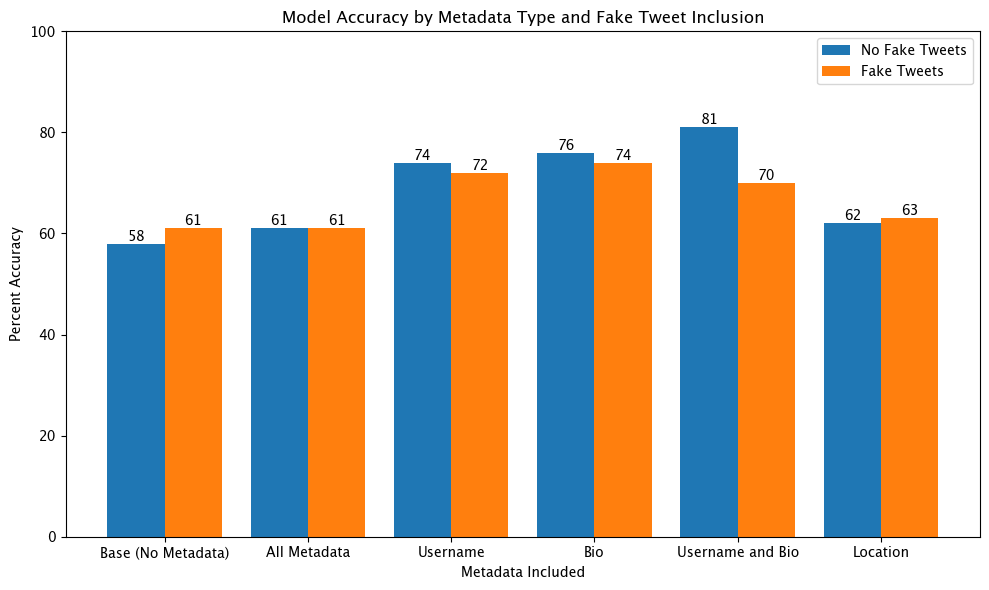

In [74]:
import numpy as np  
import matplotlib.pyplot as plt  
  
X = ['Base (No Metadata)', 'All Metadata', 'Username', 'Bio', 'Username and Bio', 'Location'] 
NoFake = [58, 61, 74, 76, 81, 62] 
Fake = [61, 61, 72, 74, 70, 63] 
  
X_axis = np.arange(len(X)) 

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = plt.bar(X_axis - 0.2, NoFake, 0.4, label='No Fake Tweets')
bars2 = plt.bar(X_axis + 0.2, Fake, 0.4, label='Fake Tweets')
  
plt.xticks(X_axis, X) 
plt.xlabel("Metadata Included") 
plt.ylabel("Percent Accuracy") 
plt.title("Model Accuracy by Metadata Type and Fake Tweet Inclusion") 
plt.legend()

for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height}', ha='center', va='bottom')

ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()
